In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import pickle
import random
import sys
from tqdm import tqdm
from sklearn import manifold

# Word2vec tutorial
## Corpus Cleaning

In [2]:
#importo el corpus
corpus = open("../Data/diario_09_11.txt", "r", encoding='utf-8').read() # read corpus
corpus[:1000] # mostrar primeras 1000 palabras

'La Justicia hizo ayer dos procedimientos por el caso de Leonardo Gabriel Bergara, el empresario de 37 años secuestrado el 22 de diciembre, en busca de posibles pistas que pudieran ayudar a dar con los captores, según informaron fuentes del caso citadas por la agencia DyN. Uno de los procedimientos fue en la casa del hermano de la víctima. El otro, en el negocio familiar que ambos atendían en el barrio de San Cristóbal.Según trascendió, en los procedimientos ordenados por la fiscal federal de Quilmes Silvia Cavallo se habría encontrado una agenda que será analizada en busca de datos que permitan avanzar en la investigación. Los policías que trabajan en el caso creen que eventualmente podría surgir de allí el nombre de algún "entregador".Por otra parte, algunas versiones indicaron que la familia del empresario secuestrado habría recibido otro pedido de dinero a través de un mensaje de texto.Los operativos judiciales se realizaron en la casa de Guillermo Bergara, hermano del joven secues

In [3]:
#armo una lista de oraciones
sent_tokenize(corpus[:1000]) 

['La Justicia hizo ayer dos procedimientos por el caso de Leonardo Gabriel Bergara, el empresario de 37 años secuestrado el 22 de diciembre, en busca de posibles pistas que pudieran ayudar a dar con los captores, según informaron fuentes del caso citadas por la agencia DyN.',
 'Uno de los procedimientos fue en la casa del hermano de la víctima.',
 'El otro, en el negocio familiar que ambos atendían en el barrio de San Cristóbal.Según trascendió, en los procedimientos ordenados por la fiscal federal de Quilmes Silvia Cavallo se habría encontrado una agenda que será analizada en busca de datos que permitan avanzar en la investigación.',
 'Los policías que trabajan en el caso creen que eventualmente podría surgir de allí el nombre de algún "entregador".Por otra parte, algunas versiones indicaron que la familia del empresario secuestrado habría recibido otro pedido de dinero a través de un mensaje de texto.Los operativos judiciales se realizaron en la casa de Guillermo Bergara, hermano del

In [4]:
############################ ir corriendo ##########
# remplazo los signos $
corpus = corpus.replace("$"," signopesos ") 
# reemplazo numeros con " num " y  paso a minuscula 
reg_num = re.compile(r"\d+[.,]?\d*") # Regular expression to search numbers
corpus = reg_num.sub(" NUM ",corpus).lower()  
corpus = sent_tokenize(corpus)
# tiro los tokens no alphabeticos 
trainset = []
for sent in tqdm(corpus):
    tokens = []#corpus
    for token in word_tokenize(sent):
        if token.isalpha():
            tokens.append(token)
    trainset.append(tokens)

100%|██████████| 492757/492757 [05:42<00:00, 1437.05it/s]


In [5]:
trainset[:2]

[['la',
  'justicia',
  'hizo',
  'ayer',
  'dos',
  'procedimientos',
  'por',
  'el',
  'caso',
  'de',
  'leonardo',
  'gabriel',
  'bergara',
  'el',
  'empresario',
  'de',
  'num',
  'años',
  'secuestrado',
  'el',
  'num',
  'de',
  'diciembre',
  'en',
  'busca',
  'de',
  'posibles',
  'pistas',
  'que',
  'pudieran',
  'ayudar',
  'a',
  'dar',
  'con',
  'los',
  'captores',
  'según',
  'informaron',
  'fuentes',
  'del',
  'caso',
  'citadas',
  'por',
  'la',
  'agencia',
  'dyn'],
 ['uno',
  'de',
  'los',
  'procedimientos',
  'fue',
  'en',
  'la',
  'casa',
  'del',
  'hermano',
  'de',
  'la',
  'víctima']]

In [6]:
print ("el corpus tiene",len(trainset), "oraciones y",sum([len(x) for x in trainset]),"palabras"   )

el corpus tiene 492757 oraciones y 13196521 palabras


In [7]:
# filtro oraciones cortas
trainset2 = [] 
for sent in trainset:
    if len(sent)>3:
        trainset2.append(sent)

print( "el corpus tiene",len(trainset2), "oraciones y",sum([len(x) for x in trainset2]),"palabras"  )

el corpus tiene 478581 oraciones y 13165766 palabras


In [8]:
# "window" es el tamaño de la ventana. windows = 10, usa 10 palabras a la izquierda y 10 palabras a la derecha
# "n_dim" es la dimension (i.e. el largo) de los vectores de word2vec
# "workers" es el numero de cores que usa en paralelo. Para aprobechar eso es necesario tener instalado Cython)
# "sample": word2vec filtra palabras que aparecen una fraccion mayor que "sample"
# "min_count": Word2vec filtra palabras con menos apariciones que  "min_count"
# "sg": para correr el Skipgram model (sg = 1), para correr el CBOW (sg = 0)
# para mas detalle ver: https://radimrehurek.com/gensim/models/word2vec.html
n_dim = 20
w2v_model = Word2Vec(trainset2, workers=4,size=n_dim, min_count = 10, window = 10, sample = 1e-3,negative=10,sg=1)

In [9]:
#w2v_model.save("word2vec_diario_20dim")  # save model

In [10]:
#w2v_model = Word2Vec.load("word2vec_diario_20dim")  # load model

In [11]:
w2v_model["arte"]  #representacion de una palabra

C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.26010847, -0.50546944,  0.8922319 ,  0.04665556,  0.8348959 ,
       -1.1109631 ,  0.2681345 , -0.2999999 , -1.002837  ,  0.5273588 ,
       -0.54600203,  0.22472575, -0.69436157, -0.63084537, -0.4364814 ,
        0.49994016,  0.06166235, -0.15564513, -0.08542261, -0.07339272],
      dtype=float32)

## Resultados

In [12]:
print ("mujer-cocina similarity:",w2v_model.wv.n_similarity(["mujer"], ["cocina"]))
print ("hombre-cocina similarity:",w2v_model.wv.n_similarity(["hombre"], ["cocina"]) )
print ("\n")
print ("mujer-esposa similarity:",w2v_model.wv.n_similarity(["mujer"], ["esposa"]) )
print ("hombre-esposo similarity:",w2v_model.wv.n_similarity(["hombre"], ["esposo"]) )
print("\n")
print ("mujer-hijos similarity:",w2v_model.wv.n_similarity(["mujer"], ["hijos"]) )
print ("hombre-hijos similarity:",w2v_model.wv.n_similarity(["hombre"], ["hijos"]) )


mujer-cocina similarity: 0.7432357
hombre-cocina similarity: 0.6294697


mujer-esposa similarity: 0.86318344
hombre-esposo similarity: 0.7598437


mujer-hijos similarity: 0.7587447
hombre-hijos similarity: 0.54690707


In [13]:
w2v_model.most_similar(positive=["biología"], negative=[], topn=25)

C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('psicología', 0.9471039175987244),
 ('química', 0.9281842708587646),
 ('evolutiva', 0.9221911430358887),
 ('neurociencias', 0.9143468141555786),
 ('conicet', 0.912735641002655),
 ('harvard', 0.9074480533599854),
 ('cardiología', 0.9014307856559753),
 ('biólogo', 0.8985505104064941),
 ('cambridge', 0.8985196948051453),
 ('ciencias', 0.8971304893493652),
 ('geología', 0.8945591449737549),
 ('científicas', 0.891644299030304),
 ('oxford', 0.8912496566772461),
 ('cognitiva', 0.8851679563522339),
 ('doctorado', 0.8845455646514893),
 ('posgrado', 0.8822621703147888),
 ('matemática', 0.8820289373397827),
 ('molecular', 0.8816229104995728),
 ('sociología', 0.8809656500816345),
 ('medicina', 0.8781298398971558),
 ('neurología', 0.8771286606788635),
 ('genética', 0.8766694068908691),
 ('ciencia', 0.876610517501831),
 ('venero', 0.8746294975280762),
 ('astronomía', 0.8744924068450928)]

In [14]:
w2v_model.most_similar(positive=["computación"], negative=[], topn=25)

C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('simulador', 0.9303625226020813),
 ('braille', 0.8899515271186829),
 ('coleccionable', 0.8880568742752075),
 ('ares', 0.8598151206970215),
 ('molecular', 0.8593714237213135),
 ('http', 0.8585629463195801),
 ('cuántica', 0.858180046081543),
 ('imperdibles', 0.8550506234169006),
 ('escaneo', 0.8540377616882324),
 ('interactivo', 0.8527212738990784),
 ('mozilla', 0.8500524759292603),
 ('detalla', 0.8500183820724487),
 ('informática', 0.849029541015625),
 ('fotográfico', 0.8482277393341064),
 ('cibernética', 0.8467729687690735),
 ('robótica', 0.8436765074729919),
 ('láser', 0.8428853750228882),
 ('diseño', 0.8405667543411255),
 ('next', 0.8405585289001465),
 ('servidor', 0.8396657705307007),
 ('búsquedas', 0.8395109176635742),
 ('quirófanos', 0.839348554611206),
 ('especializado', 0.8392287492752075),
 ('acentos', 0.8321628570556641),
 ('infografías', 0.8316435813903809)]

In [15]:
w2v_model.most_similar(positive=["amor"], negative=[], topn=15)

C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('evangelio', 0.9293608069419861),
 ('afecto', 0.9208905696868896),
 ('estribillo', 0.9093577265739441),
 ('francella', 0.9085302948951721),
 ('admiro', 0.9023862481117249),
 ('aristóteles', 0.9017959237098694),
 ('dios', 0.9001716375350952),
 ('vicio', 0.8973431587219238),
 ('frac', 0.890410304069519),
 ('devoción', 0.8885594606399536),
 ('ternura', 0.8882875442504883),
 ('alma', 0.8882352709770203),
 ('comillas', 0.8868792057037354),
 ('caín', 0.8867889642715454),
 ('enseñó', 0.8847761154174805)]

In [16]:
w2v_model.most_similar(positive=["el"], negative=[], topn=15)

C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('del', 0.9706183075904846),
 ('al', 0.967619776725769),
 ('un', 0.919380784034729),
 ('último', 0.9188518524169922),
 ('nuevo', 0.9098950028419495),
 ('en', 0.9072872996330261),
 ('ese', 0.8973143100738525),
 ('w', 0.8951588273048401),
 ('truncó', 0.88880455493927),
 ('primero', 0.8764760494232178),
 ('previo', 0.8744260668754578),
 ('primer', 0.8736397624015808),
 ('incluido', 0.868753969669342),
 ('mismo', 0.8662479519844055),
 ('desde', 0.8648314476013184)]

In [17]:
w2v_model.most_similar(positive=["la"], negative=[], topn=15)

C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('una', 0.9378613233566284),
 ('de', 0.9194812774658203),
 ('en', 0.8977823257446289),
 ('larga', 0.89225172996521),
 ('misma', 0.890815258026123),
 ('incluida', 0.8907984495162964),
 ('parte', 0.8904555439949036),
 ('nueva', 0.8853524923324585),
 ('esa', 0.8843671679496765),
 ('plena', 0.8822435736656189),
 ('esta', 0.8751164674758911),
 ('última', 0.8747380971908569),
 ('toda', 0.8661525249481201),
 ('recibida', 0.865533709526062),
 ('inédita', 0.8641985654830933)]

In [18]:
w2v_model.wv.n_similarity(["el"],["la"])

0.7714827

In [19]:
[w2v_model.wv.n_similarity(["bueno"], [i]) for i in ["querido", "malo", "músico", "blanco", "negro"]]

[0.73451537, 0.90924627, 0.41136438, 0.28382334, 0.30588436]

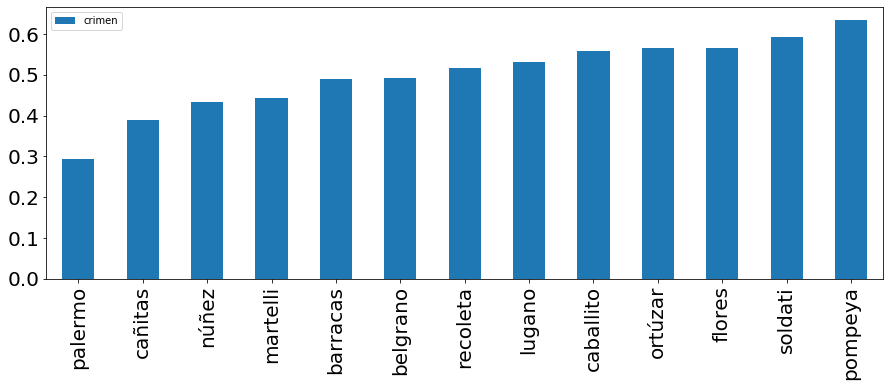

In [20]:
target_word="crimen"
barrios = ["belgrano","caballito","ortúzar","palermo","recoleta","núñez","lugano","pompeya","martelli","flores","barracas","soldati","cañitas"]
crimen = []
for word in barrios:
    crimen.append(w2v_model.wv.n_similarity([target_word], [word]))
    
pd.DataFrame(crimen,index = barrios,columns=[target_word]).sort_values(by=target_word).plot(kind="bar",figsize=(15,5), fontsize=20)

In [21]:
p_robos = ["robos","armas","asesinato","ladrones","hurto","asalto"]
p_ciencias = ["biología","química","matemática","filosofía","psicología","ciencia","ingeniería"]
p_tiempo = ["lluvioso","soleado","calor","nublado","nieve","tormenta"]
p_paises = ["suiza","suecia","francia","holanda","australia","perú","bolivia","paraguay","uruguay","brasil","colombia"]
p_comida = ["pan","fideos","galletitas","queso","pizza","cerveza","vino"]
p_tecno = ["tecnología","computadora","internet","web","hackers","monitor","mouse"]
p_hogar = ["cocina","baño","comedor","sillones","armario","sillas","mesas","vajilla"]
palabras = p_robos + p_ciencias + p_tiempo + p_paises + p_comida+p_tecno+p_hogar
colores = ["black"]*len(p_robos)+["blue"]*len(p_ciencias)+["green"]*len(p_tiempo)+["red"]*len(p_paises) +["purple"]*len(p_comida)+["orange"]*len(p_tecno)+["cyan"]*len(p_hogar)

In [22]:
# Armo una matriz de distancias
distancias=np.zeros((len(palabras),len(palabras))) #matriz cuadrada
for i,ti in enumerate(palabras):
    for j,tj in enumerate(palabras):
        distancias[i,j] = abs(1-w2v_model.wv.similarity(ti,tj))
print (distancias.shape)
distancias

(52, 52)


array([[0.00000000e+00, 4.44237471e-01, 3.33619237e-01, ...,
        8.04223627e-01, 6.02342933e-01, 5.96394122e-01],
       [4.44237471e-01, 0.00000000e+00, 4.13917303e-01, ...,
        7.68064097e-01, 8.49792436e-01, 4.87521887e-01],
       [3.33619237e-01, 4.13917303e-01, 0.00000000e+00, ...,
        8.82129259e-01, 8.44053000e-01, 7.84960955e-01],
       ...,
       [8.04223627e-01, 7.68064097e-01, 8.82129259e-01, ...,
        5.96046448e-08, 2.11850345e-01, 2.25255966e-01],
       [6.02342933e-01, 8.49792436e-01, 8.44053000e-01, ...,
        2.11850345e-01, 5.96046448e-08, 4.17326748e-01],
       [5.96394122e-01, 4.87521887e-01, 7.84960955e-01, ...,
        2.25255966e-01, 4.17326748e-01, 0.00000000e+00]])

In [23]:
# Reduccion de la dimensionalidad y visualizacion 
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 
def visualize_embeddings(distancias,palabras,colores,perplexity):
    plt.figure(figsize=(20,10))
    # Reduccion de la dimensionalidad y visualizacion 
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
                       dissimilarity="precomputed", n_jobs=4)
    Y = mds.fit(distancias).embedding_
    plt.subplot(1,2,1)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("MDS")
    # Reduccion de la dimensionalidad y visualizacion 
    tsne = TSNE(n_components=2,metric="precomputed",learning_rate=1000, random_state=123,perplexity=perplexity)
    np.set_printoptions(suppress=True)
    plt.subplot(1,2,2)
    Y = tsne.fit_transform(distancias)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("TSNE")

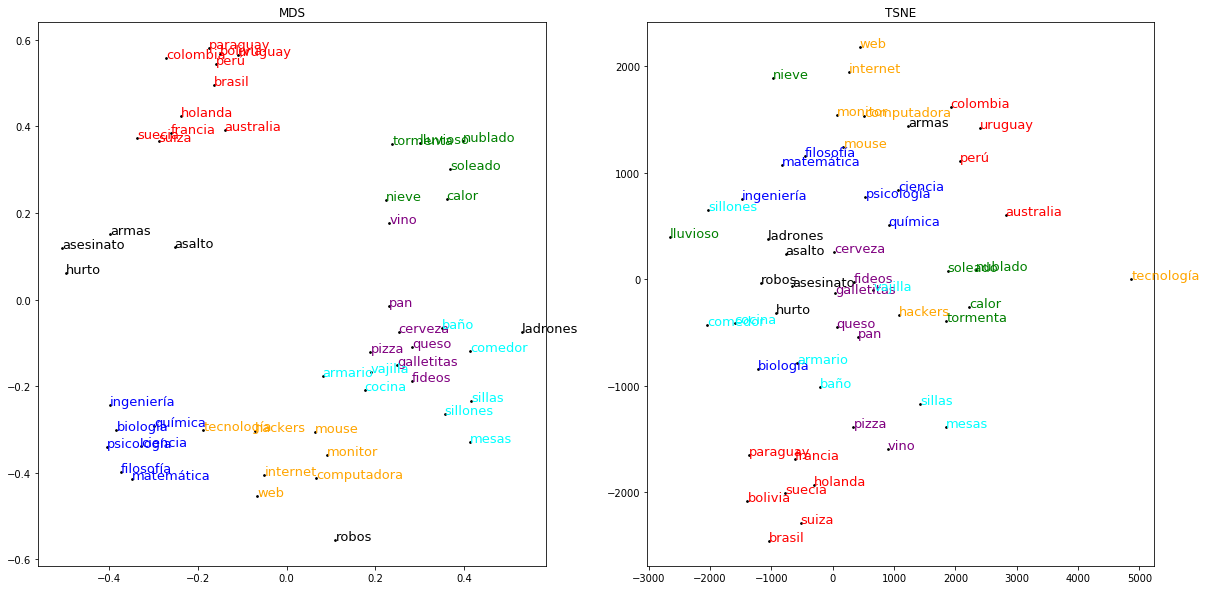

In [24]:
visualize_embeddings(distancias,palabras,colores,perplexity=10)